In [1]:
import numpy as np
from PIL import Image, ImageDraw
from acl_model import Model
import cv2
import matplotlib.pyplot as plt

In [2]:
with open("data/coco.names") as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][1:]

In [3]:
device_id = 1
input_size = 416
model_path = "./model/yolov3_coco_tf_rgb888.om"

In [4]:
model = Model(device_id, model_path, input_size, input_size)

[ACL] init resource stage:
[ACL] init resource stage success
[Model] class Model init resource stage:
[Model] create model output dataset:
[Model] create model output dataset success
model input size 1
input  0
model input dims ({'name': 'input/input_data', 'dimCount': 4, 'dims': [1, 416, 416, 3]}, 0)
model input datatype 4
model output size 3
output  0
model output dims ({'name': 'pred_sbbox/concat_2:0', 'dimCount': 5, 'dims': [1, 52, 52, 3, 85]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'pred_mbbox/concat_2:0', 'dimCount': 5, 'dims': [1, 26, 26, 3, 85]}, 0)
model output datatype 0
output  2
model output dims ({'name': 'pred_lbbox/concat_2:0', 'dimCount': 5, 'dims': [1, 13, 13, 3, 85]}, 0)
model output datatype 0
[Model] class Model init resource stage success


In [5]:
img_dict = {"path": "./data/person.jpg", "dtype": np.uint8}

In [6]:
img_org_bgr = cv2.imread(img_dict["path"])

In [14]:
# %timeit -n 50 -r 10 
bboxes = model.run(img_org_bgr)

64355170
img_buf_size 519168
[Model] create model input dataset:
[Model] create model input dataset success
[Model] execute stage:
[Model] execute stage success


In [16]:
img = Image.open(img_dict["path"])

In [17]:
img1 = ImageDraw.Draw(img)
for bbox in bboxes:
    img1.rectangle(list(bbox[:4]), outline ="red", width=2)
    print(bbox[:4], bbox[4], bbox[5], coco_labels[int(bbox[5])])

[190.81732178  97.19231415 274.56732178 365.65386963] 1.0 0.0 person
[ 65.09615326 266.32693481 208.55769348 349.98077393] 0.998046875 16.0 dog
[392.69232178 133.44232178 606.53851318 353.63464355] 0.9912185668945312 17.0 horse


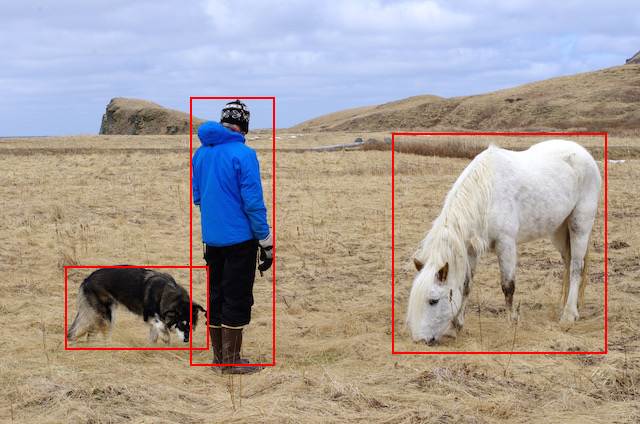

In [18]:
img